In [11]:
import numpy as np
import pandas as pd
import glob
import os
import tqdm
import matplotlib.pyplot as plt
import deepdish as dd
import seaborn as sns
from itertools import compress

In [2]:
days = ['Day 1','Day 2']
target_lure = ['target','lure']
PSPC = ['PS','PC']
ABC = {'A':'Place','B':'Animal','C':'Object'}

In [3]:
onedrive_path = 'C:/Users/tuq67942/OneDrive - Temple University/Documents/'
onedrive_datapath = onedrive_path+'Data/'
Sanity_Path = onedrive_datapath+'PSPC Sanity Check'
Eventpath = 'C:/Users/tuq67942/Desktop/R01_PSPC/'
Events = []
for Day in days:
    Events.append(pd.read_csv(Eventpath+'day'+Day[-1]+'/day'+Day[-1]+'_csv'+'/encoding_day'+Day[-1]+'.csv'))
Eventdf = pd.concat(Events,ignore_index=True)
Eventdf = Eventdf.drop(np.unique(np.where(np.column_stack([Eventdf[col].str.contains('eg', na=False) for col in Eventdf if 'image' in col]))[0])).reset_index()
xls = pd.ExcelFile('pspc_trialbytrial.xlsx')
Answer_dict = {}
Answer_dict['Day 1'] = pd.read_excel(xls,'B2_Item_status')
Answer_dict['Day 2'] = pd.read_excel(xls,'B1_Item_status')

In [4]:
# Need to code trial numbers into Answer key for B1_Item_status / Day 2 Answer_dict
# Column: "Trial_number"
day2df = pd.read_excel(xls,'B1_Item_status')
day2or = pd.read_excel(xls,'Block1_proc')
for test in day2df['List_type'].unique():
    if 'PS' in test:
        minior = day2or[day2or['List_type']==test]
        for i,(index, row) in enumerate(minior.iterrows()):
            images = [row.Image_1, row.Image_2, row.Image_3, row['Image 4']]
            for image in images:
                day2df.loc[(day2df['List_type'] == test) & (day2df['Test_image'] == image), 'Trial_number'] = i+1
Answer_dict['Day 2'] = day2df

In [5]:
xls = pd.ExcelFile('pspc_trialbytrial_KN.xlsx')
Answer_dictKN = {}
Answer_dictKN['Day 1'] = pd.read_excel(xls,'B2_Item_status')
Answer_dictKN['Day 2'] = pd.read_excel(xls,'B1_Item_status')

In [6]:
results = []
for t in target_lure:
    # Make contingency df: Events x resultdf['Type'].unique() for columns
    Contdf = pd.concat([Eventdf,pd.DataFrame(columns=['object', 'location', 'animal', 'Ab', 'Bc', 'Ba', 'Cb', 'Ac', 'Ca'])])
    for Day in days:
        df = pd.read_csv(glob.glob(Sanity_Path+'/'+Day+'/test-'+t+'/*csv')[0]).dropna(subset=['Event']).reset_index()    
        for test in PSPC:
            Answers = Answer_dict[Day][Answer_dict[Day]['List_type'].str.contains(test)]
            Sanity = df.dropna(subset=test+'_correct')
            for index, row in Sanity.iterrows():
                if test == 'PS':
                    answer = row['mouse.clicked_image'][2:-2]
                    Picture_correct = row['ans']
                    Type = Answers.loc[Answers['Test_image'] == answer]['List_type'].iloc[0].split('_')[1]
                    Status = Answers.loc[Answers['Test_image'] == answer]['Status'].iloc[0]
                    Status_temp = 1 if Status=='target' else 0 if Status=='lure' else -1
                    Controw = np.where(np.column_stack([Eventdf[col].str.contains(Picture_correct.split('.')[0], na=False) for col in Eventdf if 'image' in col]))[0][0]
                if test == 'PC':
                    answer = row['mouse_2.clicked_image'][2:-2]
                    # I think there's a bug in the 'grading'
                    if 'bike' in row['image1'] and 'bear' in row['ans1']:
                        Picture_correct = '12_B_mouse_1.png'
                    else:
                        Picture_correct = row['ans1']
                    Status_temp = int(answer == Picture_correct)
                    Status = 'target' if Status_temp else 'lure'
                    Controw = np.where(np.column_stack([Eventdf[col].str.contains(Picture_correct.split('.')[0], na=False) for col in Eventdf if 'image' in col]))[0][0]
                    # There's a bug here I need to fix
                    Type1idx = np.where(Eventdf.iloc[Controw].str.contains(row['image1'].split('.')[0]))[0][2]
                    Type1 = 'B' if Type1idx == 3 else 'C' if Type1idx == 4 else 'A'
                    Type2 = Answers.loc[(Answers['Test_image'] == Picture_correct) & (Answers['Status'] == 'target')]['List_type'].iloc[0][4]
                    Type = Type1 + Type2
                Contdf.at[Controw,Type]=Status_temp
                results.append({'Day':Day,'Target/Lure':t,'PSPC':test,'Type':Type,'Status':Status,\
                                    'Picture_chosen':answer})
resultdf = pd.DataFrame(results)


results_sum = dict()
for d in resultdf['Day'].unique():
    for p in resultdf['PSPC'].unique():
        for tt in resultdf['Type'].unique():
            new_df = resultdf[(resultdf['Day'] == d) & (resultdf['PSPC'] == p) & (resultdf['Type'] == tt)]
            if len(new_df)>0:
                temp = dict(new_df['Status'].value_counts())
                for key in temp:
                    results_sum[' '.join([d,p,tt,key])] = temp[key]

In [7]:
# Need to create a function to extract data from each participant 
def cal_results(files):
    # files are the Day 1 and Day 2 files
    results = []
    results_sum = dict()
    # Make contingency df: Events x resultdf['Type'].unique() for columns
    Contdf = pd.concat([Eventdf,pd.DataFrame(columns=['object', 'location', 'animal', 'Ab', 'Bc', 'Ba', 'Cb', 'Ac', 'Ca'])])
    for f in files:
        Day = 'Day '+f.split(onedrive_datapath)[1].split('day')[1][0]
        df = pd.read_csv(f).dropna(subset=['Event']).reset_index()
        for test in PSPC:
            Answers = Answer_dict[Day][Answer_dict[Day]['List_type'].str.contains(test)]
            testdf = df.dropna(subset=test+'_correct')
            for index, row in testdf.iterrows():
                if test == 'PS':
                    answer = row['mouse.clicked_image'][2:-2]
                    Picture_correct = row['ans']
                    Type = Answers.loc[Answers['Test_image'] == answer]['List_type'].iloc[0].split('_')[1]
                    Status = Answers.loc[Answers['Test_image'] == answer]['Status'].iloc[0]
                    Status_temp = 1 if Status=='target' else 0 if Status=='lure' else -1
                    Controw = np.where(np.column_stack([Eventdf[col].str.contains(Picture_correct.split('.')[0], na=False) for col in Eventdf if 'image' in col]))[0][0]
                if test == 'PC':
                    answer = row['mouse_2.clicked_image'][2:-2]
                    # I think there's a bug in the 'grading'
                    if 'bike' in row['image1'] and 'bear' in row['ans1']:
                        Picture_correct = '12_B_mouse_1.png'
                    else:
                        Picture_correct = row['ans1']
                    Status_temp = int(answer == Picture_correct)
                    Status = 'target' if Status_temp else 'lure'
                    Controw = np.where(np.column_stack([Eventdf[col].str.contains(Picture_correct.split('.')[0], na=False) for col in Eventdf if 'image' in col]))[0][0]
                    # There's a bug here I need to fix
                    Type1idx = np.where(Eventdf.iloc[Controw].str.contains(row['image1'].split('.')[0]))[0][2]
                    Type1 = 'B' if Type1idx == 3 else 'C' if Type1idx == 4 else 'A'
                    Type2 = Answers.loc[(Answers['Test_image'] == Picture_correct) & (Answers['Status'] == 'target')]['List_type'].iloc[0][4]
                    Type = Type1 + Type2
                Contdf.at[Controw,Type]=Status_temp
                results.append({'Day':Day,'Target/Lure':t,'PSPC':test,'Type':Type,'Status':Status,\
                                    'Picture_chosen':answer})
    resultdf = pd.DataFrame(results)

    resultdf = pd.DataFrame(results)
    for d in resultdf['Day'].unique():
        for p in resultdf['PSPC'].unique():
            for tt in resultdf['Type'].unique():
                new_df = resultdf[(resultdf['Day'] == d) & (resultdf['PSPC'] == p) & (resultdf['Type'] == tt)]
                if len(new_df)>0:
                    temp = dict(new_df['Status'].value_counts())
                    for key in temp:
                        results_sum[' '.join([d,p,tt,key])] = temp[key]
    return results_sum, Contdf

In [30]:

data = []
# ensure that data for Day 1 and Day 2 are present
# save whether Day 1 and Day 2 were both during Session 1 or not
# a list of all subjects with data
for year in [1,2,3]:
    MDEM_path = onedrive_datapath+'Year '+str(year)+'/MDEM*/Sess*/*test*.csv'
    MDEM_path2 = onedrive_datapath+'Year '+str(year)+'/MDEM*/*test*.csv'
    data_tmp = glob.glob(MDEM_path)+glob.glob(MDEM_path2)
    for d in data_tmp:
        d_ = d.split('/')[-1].split('\\')[1]
        if os.path.getsize(d) > 50000 and any(char.isdigit() for char in d_):
            if sum(d_ in s for s in data_tmp) > 1:
                session_list = [s.split('/')[-1].split('\\')[2] for s in list(compress(data_tmp, [d_ in s for s in data_tmp]))]
                if session_list[0]==session_list[1] or 'MDEM' in session_list[0]:
                    same_day = True  
                else: 
                    same_day = False
                dictionary = {'Subject':d_,'Same_Day':same_day,'Year':year}
                if dictionary not in data:
                    data.append(dictionary)
datadf = pd.DataFrame(data)
datadf = datadf[~datadf.Subject.str.contains("TEST")]

In [31]:
# Download newest demographics spreadsheet from Redcap, and put in this folder
# Add age and sex demographics to datadf
demofiles = glob.glob(onedrive_datapath+'R01MarvelousMoments*')
demofile = max(demofiles, key=os.path.getctime)
df = pd.read_csv(demofile).dropna(subset = ['demo_age'])
df = df[['redcap_event_name','session_date','participant_id','demo_age','demo_child_gender','kbit_std_v']]
df = df.dropna(subset = ['session_date'])
conditions = [
    df['redcap_event_name'].str.contains('year1'),
    df['redcap_event_name'].str.contains('year2'),
    df['redcap_event_name'].str.contains('year3'),
]
values = [1,2,3]
df['Year'] = np.select(conditions, values)
# only analyzing year 1 data!
#df = df[(df.redcap_event_name.str.contains('year1'))]
# segregate subjects on basis of 1 week delay or not (create new column)
df['Delay'] = df.apply(lambda row: row.session_date > "2023-03-01", axis=1)
df=df.drop(['session_date','redcap_event_name'],axis=1)
#datadf = datadf.join(df.set_index('participant_id'), on='Subject')
datadf = pd.merge(datadf, df,  how='left', left_on=['Subject','Year'], right_on = ['participant_id','Year'])
datadf = datadf.rename({'demo_age': 'Age', 'demo_child_gender': 'Gender','Same_Day':'Same Day'}, axis='columns')
datadf.loc[datadf['Gender'] == 1,'Gender'] = 'Boys'
datadf.loc[datadf['Gender'] == 2,'Gender'] = 'Girls'

In [32]:
Contdict = {k:{} for k in [1,2,3]} # contains contingency tables per subject
for index, row in tqdm.tqdm(datadf.iterrows()):
    subject = row.Subject
    year = str(row.Year)
    files = glob.glob(onedrive_datapath+'Year '+year+'/'+subject+'/Sess*/*test*.csv')
    files = [f for f in files if os.path.getsize(f) > 50000]
    results_sum,Contdict[int(year)][subject] = cal_results(files)
    for key in results_sum:
        if key not in datadf:
            datadf[key] = 0
        datadf.loc[index, key] = results_sum[key]
        
dd.io.save('csvs/PSPC_cont_tables.h5',Contdict)
datadf.to_csv('csvs/datadf.csv',index=False)
# Need to figure out where NaNs are coming from in Contdict! 
    

99it [00:22,  4.48it/s]


In [17]:
# Download Pilot data here:
data_tmp = glob.glob(onedrive_datapath+'/PSPC Pilot/'+'Pilot*/*test*csv')

demofile = glob.glob(onedrive_datapath+'/PSPC Pilot/*xlsx')[0]
df = pd.read_excel(demofile, parse_dates=True, engine="openpyxl")
# not needed: df['LastDigit'] = df['MDEM ID'].str.strip().str[-1]
pilotdata = []
for d in data_tmp:
    d_ = d.split('/')[-1].split('\\')[1]
    if os.path.getsize(d) > 50000 and any(char.isdigit() for char in d_):
        # including even partially complete data:
        if sum(d_ in s for s in data_tmp) >= 1:
            row = df.loc[df['MDEM ID'] == d_]
            if '24' in row['Condition'].iloc[0]:
                age_components = row['Precise Age (at time of session)'].iloc[0].split(' ')
                age = int(age_components[0])+ int(age_components[2])/12
                condition = row['Condition'].iloc[0]
                dictionary = {'Subject':d_,'Age':age,'Condition':condition}
                if dictionary not in pilotdata:
                    pilotdata.append(dictionary)
pilotdatadf = pd.DataFrame(pilotdata)
Contdictpilot = {} # contains contingency tables per subject
for index, row in pilotdatadf.iterrows():
    subject = row.Subject
    files = glob.glob(onedrive_datapath+'PSPC Pilot/'+subject+'/*test*.csv')
    files = [f for f in files if os.path.getsize(f) > 50000]
    results_sum,Contdictpilot[subject] = cal_results(files)
    for key in results_sum:
        if key not in datadf:
            datadf[key] = 0
        pilotdatadf.loc[index, key] = results_sum[key]
        
dd.io.save('csvs/Pilot_cont_tables.h5',{**Contdict, **Contdictpilot})
df = pd.concat([datadf, pilotdatadf])
df.to_csv('csvs/pilotdatadf.csv',index=False)





PermissionError: [Errno 13] Permission denied: 'C:/Users/tuq67942/OneDrive - Temple University/Documents/Data//PSPC Pilot\\PSPC Piloting Participant Log.xlsx'

In [11]:
# summary columns:
datadf['Day 1 PS Target'] = datadf[[d for d in datadf.columns if 'Day 1' in d and 'PS' in d and 'target' in d]].sum(axis=1)
datadf['Day 2 PS Target'] = datadf[[d for d in datadf.columns if 'Day 2' in d and 'PS' in d and 'target' in d]].sum(axis=1)
datadf['Day 1 PS Lure'] = datadf[[d for d in datadf.columns if 'Day 1' in d and 'PS' in d and 'lure' in d]].sum(axis=1)
datadf['Day 2 PS Lure'] = datadf[[d for d in datadf.columns if 'Day 2' in d and 'PS' in d and 'lure' in d]].sum(axis=1)

datadf['Day 1 PC Target'] = datadf[[d for d in datadf.columns if 'Day 1' in d and 'PC' in d and 'target' in d]].sum(axis=1)
datadf['Day 2 PC Target'] = datadf[[d for d in datadf.columns if 'Day 2' in d and 'PC' in d and 'target' in d]].sum(axis=1)
datadf['Day 1 PC Lure'] = datadf[[d for d in datadf.columns if 'Day 1' in d and 'PC' in d and 'lure' in d]].sum(axis=1)
datadf['Day 2 PC Lure'] = datadf[[d for d in datadf.columns if 'Day 2' in d and 'PC' in d and 'lure' in d]].sum(axis=1)

datadf['PS Target'] = datadf[[d for d in datadf.columns if 'PS' in d and 'target' in d]].sum(axis=1)
datadf['PS Lure'] = datadf[[d for d in datadf.columns if 'PS' in d and 'lure' in d]].sum(axis=1)
   
datadf['PC Target'] = datadf[[d for d in datadf.columns if 'PC' in d and 'target' in d]].sum(axis=1)
datadf['PC Lure'] = datadf[[d for d in datadf.columns if 'PC' in d and 'lure' in d]].sum(axis=1)
         

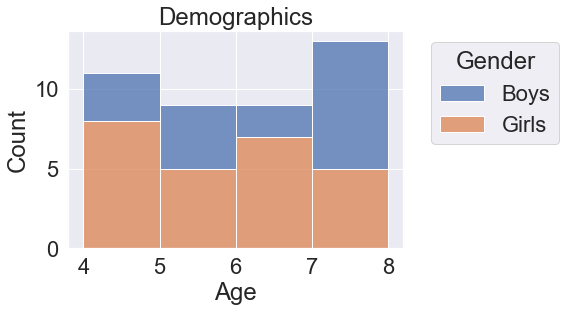

In [12]:
temp= datadf.reindex(np.concatenate((np.array([1,0]),np.arange(2,len(datadf)))))
sns.set(font_scale=2)
g = sns.histplot(data=temp, x="Age", hue="Gender", multiple="stack",bins=np.arange(4,9))
g.set_xticks(np.arange(4,9)) # <--- set the ticks first
g.set_xticklabels(np.arange(4,9))
g.set_title('Demographics')
sns.move_legend(g, "upper right", bbox_to_anchor=(1.5, 1))
fig = g.get_figure()
fig.savefig(onedrive_path+'Figures/'+'Demographics.png', bbox_inches='tight', dpi=100)

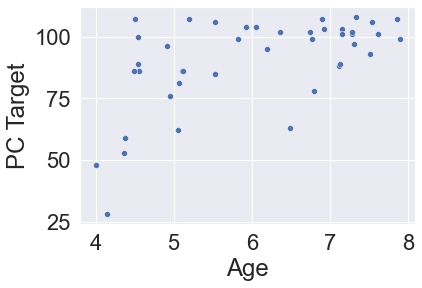

In [13]:
g = sns.scatterplot(data=datadf,  x='Age', y='PC Target')

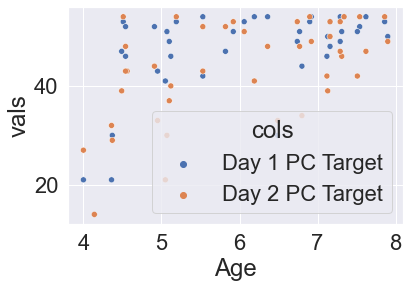

In [14]:
temp = datadf[['Age', 'Day 1 PC Target','Day 2 PC Target']]
dfm = temp.melt('Age', var_name='cols', value_name='vals')
g = sns.scatterplot(x="Age", y="vals", hue='cols', data=dfm)

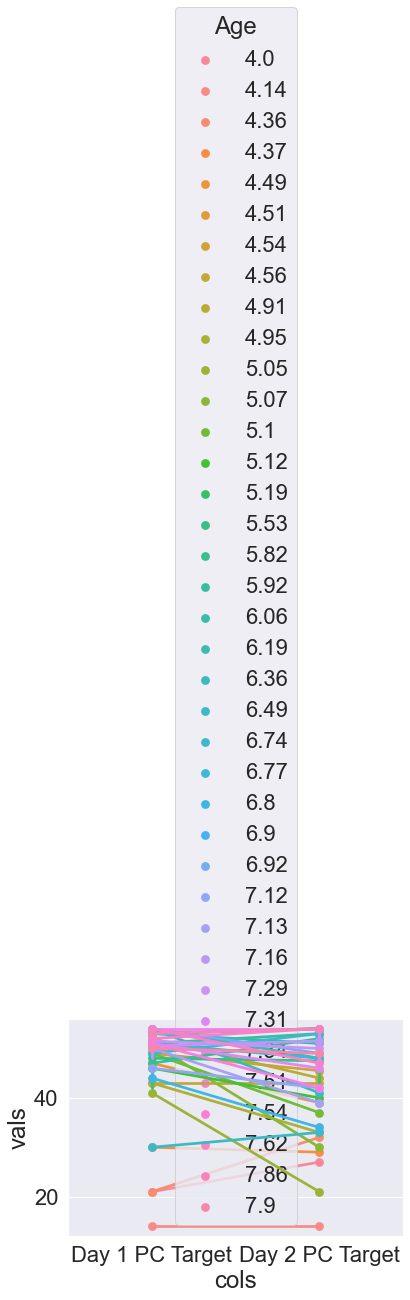

In [15]:
temp = datadf[['Age', 'Day 1 PC Target','Day 2 PC Target']]
dfm = temp.melt('Age', var_name='cols', value_name='vals')
g = sns.pointplot(x="cols", y="vals", hue='Age', data=dfm)

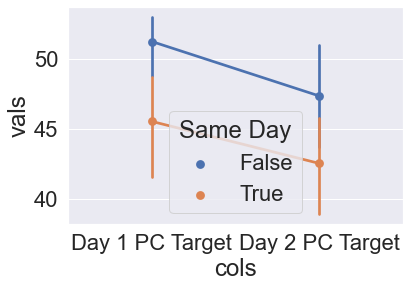

In [16]:
temp = datadf[['Same Day', 'Day 1 PC Target','Day 2 PC Target']]
dfm = temp.melt('Same Day', var_name='cols', value_name='vals')
g = sns.pointplot(x="cols", y="vals", hue='Same Day', data=dfm)

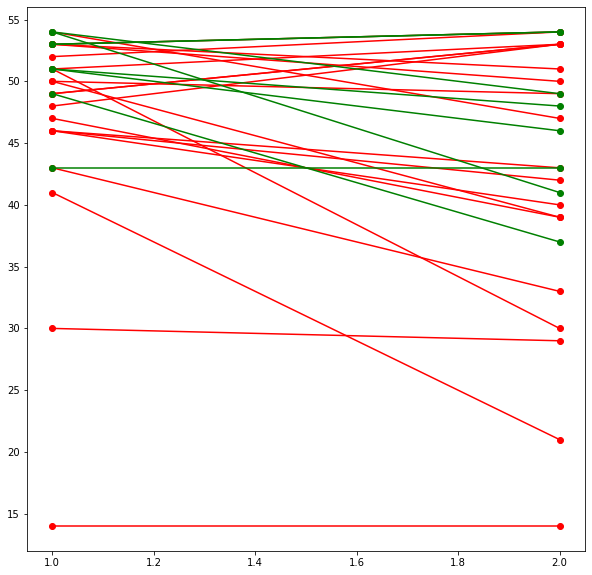

In [63]:
fig = plt.figure(figsize =(10, 10))

c = ['r','g']
for i,sd in enumerate([True,False]):
    tmp = datadf[datadf['Same Day'] == sd]
    for ii in range(len(tmp)):
        plt.plot([1,2],[tmp['Day 1 PC Target'].iloc[ii], tmp['Day 2 PC Target'].iloc[ii]],'o-',color = c[i])
plt.show()

C:\Users\tuq67942\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tuq67942\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tuq67942\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tuq67942\Anac

<AxesSubplot:xlabel='PS Lure'>

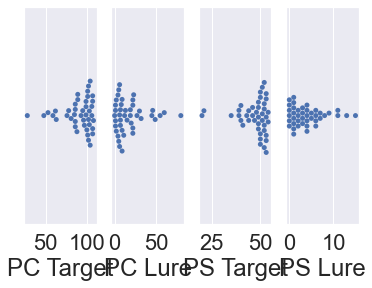

In [14]:
fig, ax =plt.subplots(1,4)
sns.swarmplot(datadf['PC Target'], ax=ax[0])
sns.swarmplot(datadf['PC Lure'], ax=ax[1])
sns.swarmplot(datadf['PS Target'], ax=ax[2])
sns.swarmplot(datadf['PS Lure'], ax=ax[3])